In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.tools import get_raster_data, read_geojson, show, save_raster_and_write_meta
import matplotlib.pyplot as plt


In [2]:
sam = SamGeo2(
    model_id="sam2-hiera-large",
    automatic=False,
    device="cuda"
)

## A. Getting a satellite image and export it to a GeoTiff file

In [ ]:
m = leafmap.Map(center=[12.94316, 101.001263], zoom=16, height="800px")
m.add_basemap("Satellite")
m

In [ ]:
if m.user_roi is not None:
    bbox = m.user_roi_bounds()
    coordinates = m.user_rois['features'][0]['geometry']['coordinates'][0]
else:
    bbox = [100.9230026816609, 13.054297390119896, 100.9261026816609, 13.052397390099848] 
    coordinates = [
        [bbox[0], bbox[3]],  # Top-left corner (min_lon, max_lat)
        [bbox[2], bbox[3]],  # Top-right corner (max_lon, max_lat)
        [bbox[2], bbox[1]],  # Bottom-right corner (max_lon, min_lat)
        [bbox[0], bbox[1]],  # Bottom-left corner (min_lon, min_lat)
        [bbox[0], bbox[3]]   # Closing the polygon by repeating the first point
        ]

In [ ]:
clipped_satellite_file = "clipped_satellite.tif"  

leafmap.map_tiles_to_geotiff(
    output=clipped_satellite_file, bbox=bbox, zoom=18, source="Satellite", overwrite=True
)

In [ ]:
selected_coordinates = {} 
selected_coordinates["bbox"] = bbox
selected_coordinates["coordinates"] = coordinates
 

file_path = 'selected_coordinates.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(selected_coordinates, file)

## B. Processing and saving GeoTiff files

In [ ]:
clipped_image_file = "clipped_image.tif"
clipped_satellite_file = "clipped_satellite.tif"

clipped_image     = tifffile.imread(clipped_image_file)  
clipped_satellite = tifffile.imread(clipped_satellite_file) 

In [ ]:
normalized_img = cv2.normalize(clipped_image, None, 0, 128, cv2.NORM_MINMAX)  # Normalize to 0-1 range
normalized_img_uint8 = normalized_img.astype(np.uint8)  

In [ ]:
normalized_img.shape

In [ ]:
red_channel = normalized_img_uint8[:, :, 0].ravel()
green_channel = normalized_img_uint8[:, :, 1].ravel()
blue_channel = normalized_img_uint8[:, :, 2].ravel()

# Compute histograms for each channel
hist_r, _ = np.histogram(red_channel, bins=256, range=(0, 256))
hist_g, _ = np.histogram(green_channel, bins=256, range=(0, 256))
hist_b, bin_edges = np.histogram(blue_channel, bins=256, range=(0, 256))

plt.bar(bin_edges[:-1], hist_r, width=1, color='r', edgecolor='none', alpha=0.5, label='Red')
plt.bar(bin_edges[:-1], hist_g, width=1, color='g', edgecolor='none', alpha=0.5, label='Green') 
plt.bar(bin_edges[:-1], hist_b, width=1, color='b', edgecolor='none', alpha=0.5, label='Blue')  
plt.xlim([0, 256]) # Set the x-axis range from 0 to 256
plt.show()

In [ ]:
from skimage import exposure
p2, p98 = np.percentile(red_channel, (2, 98))
red_ch_rescale = exposure.rescale_intensity(red_channel, in_range=(p2, p98))

p2, p98 = np.percentile(green_channel, (2, 98))
green_ch_rescale = exposure.rescale_intensity(green_channel, in_range=(p2, p98))

p2, p98 = np.percentile(blue_channel, (2, 98))
blue_ch_rescale = exposure.rescale_intensity(blue_channel, in_range=(p2, p98))

normalized_img[:,:,0] = red_ch_rescale.reshape(normalized_img.shape[0], normalized_img.shape[1])
normalized_img[:,:,1] = green_ch_rescale.reshape(normalized_img.shape[0], normalized_img.shape[1])
normalized_img[:,:,2] = blue_ch_rescale.reshape(normalized_img.shape[0], normalized_img.shape[1])

In [ ]:
# Define file paths
input_file = 'clipped_image.tif'
clipped_image_file = 'post_clipped_image.tif'

# Open the source GeoTIFF file in read mode ('r' is default)
with rasterio.open(input_file) as src:
    # Read the raster data into a numpy array
    image_array = src.read() # Read the first band (adjust for multi-band rasters)

    # Get a copy of the source file's metadata (profile)
    profile = src.profile

    # Perform modifications on the numpy array
    # Example: Change all pixel values below 10000 to a new value (e.g., 9999)
    modified_array = normalized_img.transpose(2, 0, 1)

# Update the profile for the output file
# Ensure the dtype (data type) matches the modified array
profile.update(
    dtype=modified_array.dtype,
    count=4, # Number of bands (1 in this example)
    compress='lzw' # Optional: add compression
)

# Open the new GeoTIFF file in write mode ('w') and write the modified array
with rasterio.open(clipped_image_file, 'w', **profile) as dst:
    dst.write(modified_array) # Write the modified array to band 1

print(f"Modified image saved to {clipped_image_file}")

 

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 15))

axs[0].imshow(normalized_img[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
axs[0].set_title('Theos') # Set a title for the first subplot
axs[0].axis('off') # Optional: turn off axis ticks for a cleaner image display

axs[1].imshow(clipped_satellite[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[1].set_title('Google') # Set a title for the second subplot
axs[1].axis('off') #

In [ ]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m

## C. Using GeoSam2 to mask objects in a satellite image

In [ ]:
sam = SamGeo2(
    model_id="sam2-hiera-large",
    automatic=False,
    device="cuda"
)

In [ ]:
sam_input_image = clipped_satellite_file
# sam_input_image = clipped_image_file

In [ ]:
sam.set_image(sam_input_image)
sam.show_map(out_dir="sam_output")

## D. View masks and detected objects

In [ ]:
# raster files
clipped_image_file = "clipped_image.tif" 
clipped_satellite_file = "clipped_satellite.tif"

# from SamGeo2
center_geojson  = "sam_output/masks_new_fg_markers.geojson" 
extracted_masks = "sam_output/masks_new.tif"
gpkg_path       = "sam_output/masks_new_rect.gpkg"

In [ ]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8
)
m.add_raster(extracted_masks, cmap="jet", nodata=0, opacity=0.7, layer_name="Building masks")
m.add_vector(gpkg_path, layer_name="Rect")
m

In [ ]:
m

## E. Making the bounding boxes

In [3]:
extracted_masks = "sam_output/masks_new.tif"
center_geojson  = "sam_output/masks_new_fg_markers.geojson" 

In [4]:
mask, tif_data, [lons, lats], [rows, cols] = get_raster_data(extracted_masks)

Dataset name: sam_output/masks_new.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


In [5]:
# A mask is an np.array that contains detected labels. The maximum value of the labels will be equal to the number of forground objects:
mask.max()

np.int32(94)

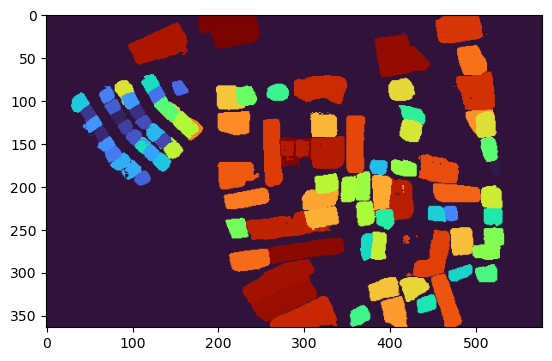

In [6]:
# In order to view those masks, we need to convert it to uint8 datatype.
mask_uint8 = mask.astype(np.uint8)
plt.imshow(mask_uint8[0,:,:], cmap='turbo')

In [7]:
from pyproj import Transformer

x_str, y_str = tif_data.xy(0, 0)
transformer = Transformer.from_crs(tif_data.crs, "EPSG:4326", always_xy=True)
lon_0, lat_0 = transformer.transform(x_str, y_str)

x_end, y_end = tif_data.xy(364, 578)
transformer = Transformer.from_crs(tif_data.crs, "EPSG:4326", always_xy=True)
lon_end, lat_end = transformer.transform(x_end, y_end)

top_left_coordinates     = [lon_0, lat_0] # long, lat 
bottom_right_coordinates = [lon_end, lat_end]  # long, lat 

image_height = mask.shape[1]
image_width = mask.shape[2]


def latlng_to_pixel(long, lat):
    lat      = lat

    min_long = min(top_left_coordinates[0], bottom_right_coordinates[0])
    max_long = max(top_left_coordinates[0], bottom_right_coordinates[0])

    min_lat  = min(top_left_coordinates[1], bottom_right_coordinates[1])
    max_lat  = max(top_left_coordinates[1], bottom_right_coordinates[1]) 

    pixel_x =  ((long - min_long) / (max_long - min_long))*image_width  
    pixel_y =  (1-(lat - min_lat) / (max_lat - min_lat))*image_height  
    pixel = [int(pixel_x), int(pixel_y)] 
    return pixel

In [ ]:
center = read_geojson(center_geojson)
center["longitude"] = center.geometry.x
center["latitude"]  = center.geometry.y

pixel_x = []
pixel_y = []
for long, lat in zip(center["longitude"].tolist(), center["latitude"].tolist()):
    pixel_xy = latlng_to_pixel(long, lat)
    pixel_x.append(pixel_xy[0])
    pixel_y.append(pixel_xy[1])

In [ ]:
plt.imshow(mask_uint8[0,:,:], cmap='turbo')
plt.scatter(pixel_x, pixel_y, c='cyan', s=10)

In [ ]:
from torchvision.ops import masks_to_boxes
import torch

tensor = torch.tensor(mask_uint8[0,:,:], dtype=torch.uint8)

label_id = torch.unique(tensor)
torch_masks_list = []
for id in label_id.tolist(): 
    bool_image = (1*(tensor == id)) 
    torch_masks_list.append(bool_image.view(1, tensor.shape[0], tensor.shape[1]))

torch_masks = torch.concat(torch_masks_list)
boxes = masks_to_boxes(torch_masks)

boxes_np =  boxes[1:,:].numpy().tolist()

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
# Display background (e.g., zeros) 
ax.scatter(pixel_x, pixel_y, c='cyan', s=10) 
ax.imshow(mask_uint8[0,:,:], cmap='turbo')


# Iterate through boxes and add patches
for box in boxes_np:
    # box format is [xmin, ymin, xmax, ymax]
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), width, height, 
                            linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import box

def convert_pixel_to_longlat(y, x):
    x_end, y_end = tif_data.xy(y, x)
    transformer = Transformer.from_crs(tif_data.crs, "EPSG:4326", always_xy=True)
    lon_end, lat_end = transformer.transform(x_end, y_end)
    return lon_end, lat_end 


boxes_np_list = list(boxes_np)

longlat_boxes = []

for x_min, y_min, x_max, y_max in boxes_np_list:
    lon_min, lat_min = convert_pixel_to_longlat(y_min, x_min)
    lon_max, lat_max = convert_pixel_to_longlat(y_max, x_max)

    longlat_boxes.append([lon_min, lat_min, lon_max, lat_max]) 

polygons = [box(minx, miny, maxx, maxy) for minx, miny, maxx, maxy in longlat_boxes]

# 3. Create GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

# 4. Save to GeoJSON
gdf.to_file("bounding_boxes.geojson", driver='GeoJSON')


In [ ]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image")
m.add_raster(clipped_image_file, layer_name="Theos")
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8
)
m.add_raster(extracted_masks, cmap="jet", nodata=0, opacity=0.7, layer_name="Building masks")
m.add_vector("bounding_boxes.geojson", layer_name="Bounding Boxes")
m

## F. Improving the masks

In [8]:
def filling_holes(gray):

    des = cv2.bitwise_not(gray)
    contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contour:
        cv2.drawContours(des,[cnt],0, 255,-1)

    gray = cv2.bitwise_not(des)

    return gray

def erosion(gray, kernel_size=5):

    # Creating kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Using cv2.erode() method 
    gray = cv2.erode(gray, kernel, iterations=1) 

    return gray

def dilation(gray, kernel_size=5):

    # Creating kernel
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Using cv2.erode() method 
    gray = cv2.dilate(gray, kernel) 

    return gray


In [9]:
from sklearn.metrics.pairwise import euclidean_distances

def mapping_manual_and_mask_point(mask, pixel_x, pixel_y):

    mapping_manual_to_mask = {}
    mapping_mask_to_manual = {}
    manually_chosen_index_list = []
    for mask_index in range(0, mask.max()+1): 
        gray_bf                = 1*(mask[0,:,:] == mask_index)  # Convert to grayscale by taking one channel
        (gray_bf_y, gray_bf_x) = np.nonzero(gray_bf)
        gray_bf_xy             = np.concatenate([gray_bf_x.reshape(-1,1), gray_bf_y.reshape(-1,1)], axis=1)  
        ref_xy                 = np.concatenate([np.array(pixel_x).reshape(-1,1), np.array(pixel_y).reshape(-1,1)], axis=1) 
        distances              = euclidean_distances(gray_bf_xy, ref_xy)  
        closest_point          = ref_xy[distances.argmin(axis=1)[0]]

        manually_chosen_ = np.argsort(np.mean(distances, axis=0))[:2]

        manually_chosen_index = manually_chosen_[0].item()

        if manually_chosen_[0] not in manually_chosen_index_list:
            manually_chosen_index_list.append(manually_chosen_index) 

        elif manually_chosen_index in manually_chosen_index_list:
            manually_chosen_index = manually_chosen_[1].item()
            manually_chosen_index_list.append(manually_chosen_index)

        elif manually_chosen_index in manually_chosen_index_list:
            manually_chosen_index = manually_chosen_[2].item()
            manually_chosen_index_list.append(manually_chosen_index) 

        mapping_manual_to_mask[manually_chosen_index] = mask_index
        mapping_mask_to_manual[mask_index] = manually_chosen_index

    return mapping_manual_to_mask, mapping_mask_to_manual

In [10]:
clipped_satellite_file = "clipped_satellite.tif"
image, _, _, _ = get_raster_data(clipped_satellite_file) 
image = np.transpose(image, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

Dataset name: clipped_satellite.tif
File mode: r
Number of bands: 3
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 364, 578)
Data type: uint8


In [11]:
extracted_masks = "sam_output/masks_new.tif"
mask, tif_data, [lons, lats], [rows, cols] = get_raster_data(extracted_masks)
mask_uint8 = mask.astype(np.uint8) # mask max value = 105

Dataset name: sam_output/masks_new.tif
File mode: r
Number of bands: 1
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (1, 364, 578)
Data type: int32


In [12]:
center_geojson  = "sam_output/masks_new_fg_markers.geojson" 

center = read_geojson(center_geojson)
center["longitude"] = center.geometry.x
center["latitude"]  = center.geometry.y

pixel_x = []
pixel_y = []
for long, lat in zip(center["longitude"].tolist(), center["latitude"].tolist()):
    pixel_xy = latlng_to_pixel(long, lat)
    pixel_x.append(pixel_xy[0])
    pixel_y.append(pixel_xy[1])

In [13]:
mapping_manual_to_mask, mapping_mask_to_manual = mapping_manual_and_mask_point(mask, pixel_x, pixel_y)

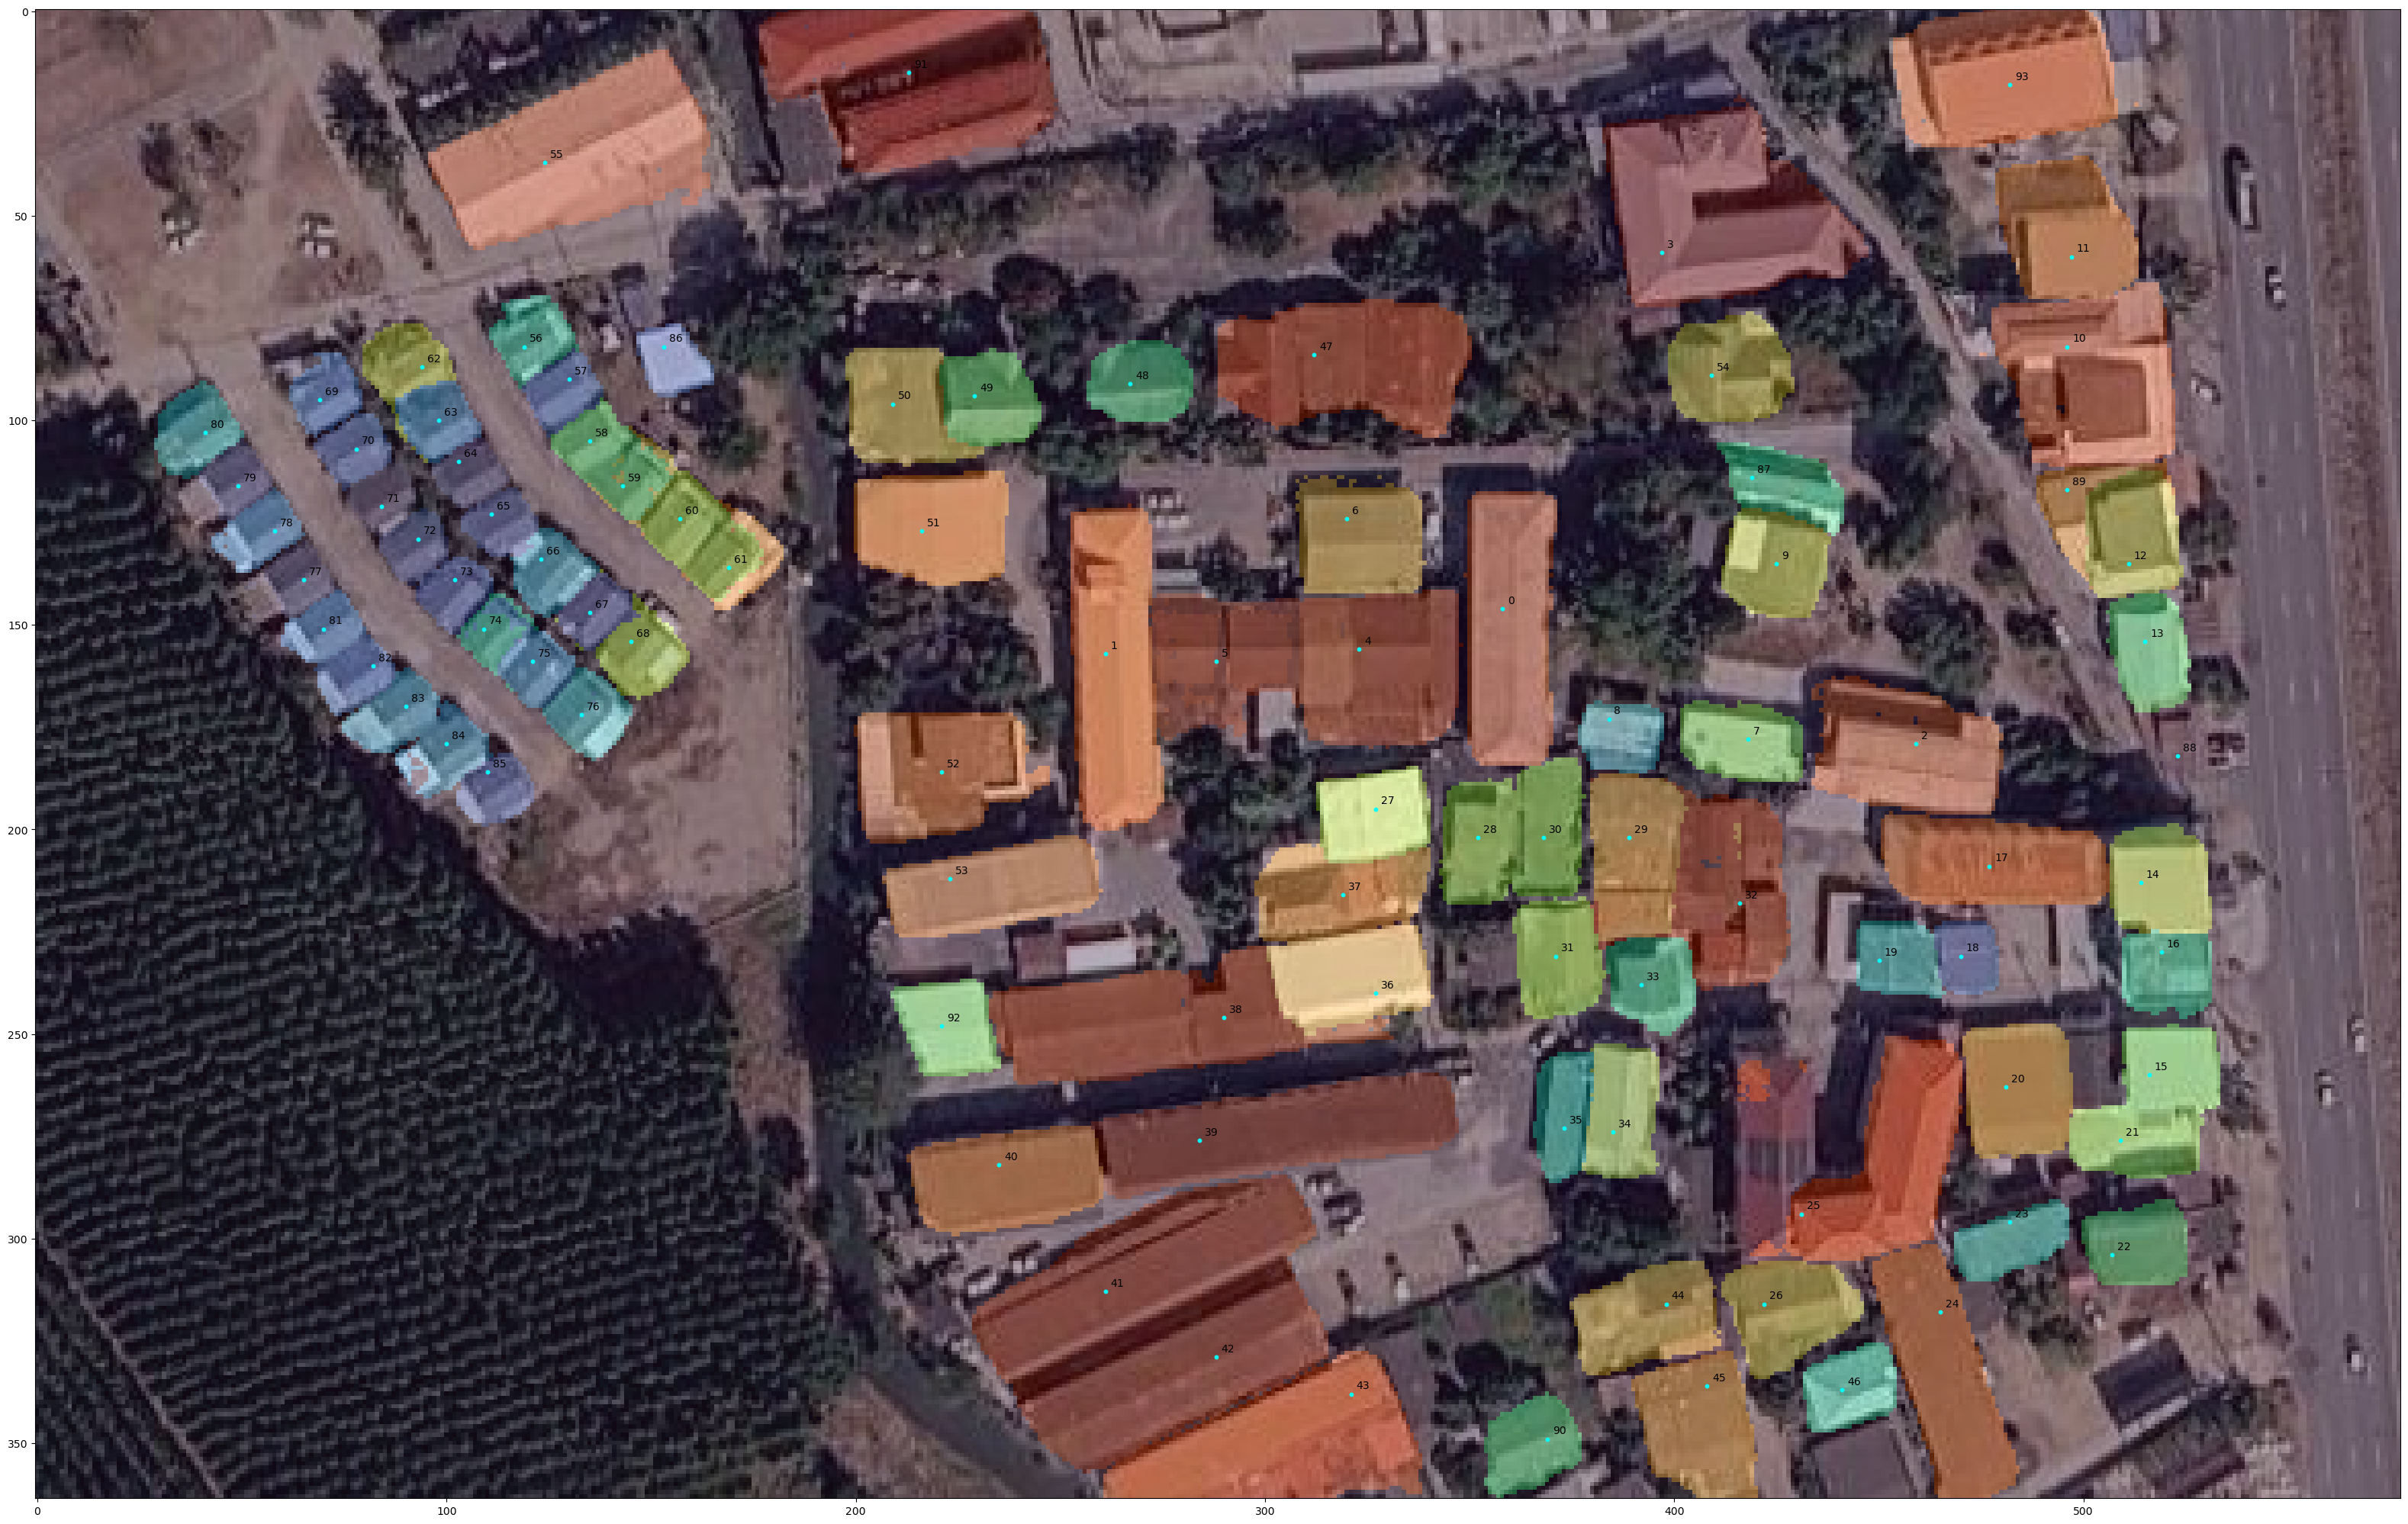

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(40, 30))
axs.imshow(image)
axs.imshow(mask_uint8[0,:,:], cmap='turbo', alpha=0.35)
axs.scatter(pixel_x, pixel_y, c='cyan', s=10)

for label, (x, y) in enumerate(zip(pixel_x, pixel_y)):
    # Place the text at the coordinates (x[i], y[i])
    # The 'xytext' argument can be used to offset the text from the point
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points')


### Choose the (manual) index to be corrected 

In [15]:
manual_index = 25

In [16]:
mask_id = mapping_manual_to_mask[manual_index]
mask_id

79

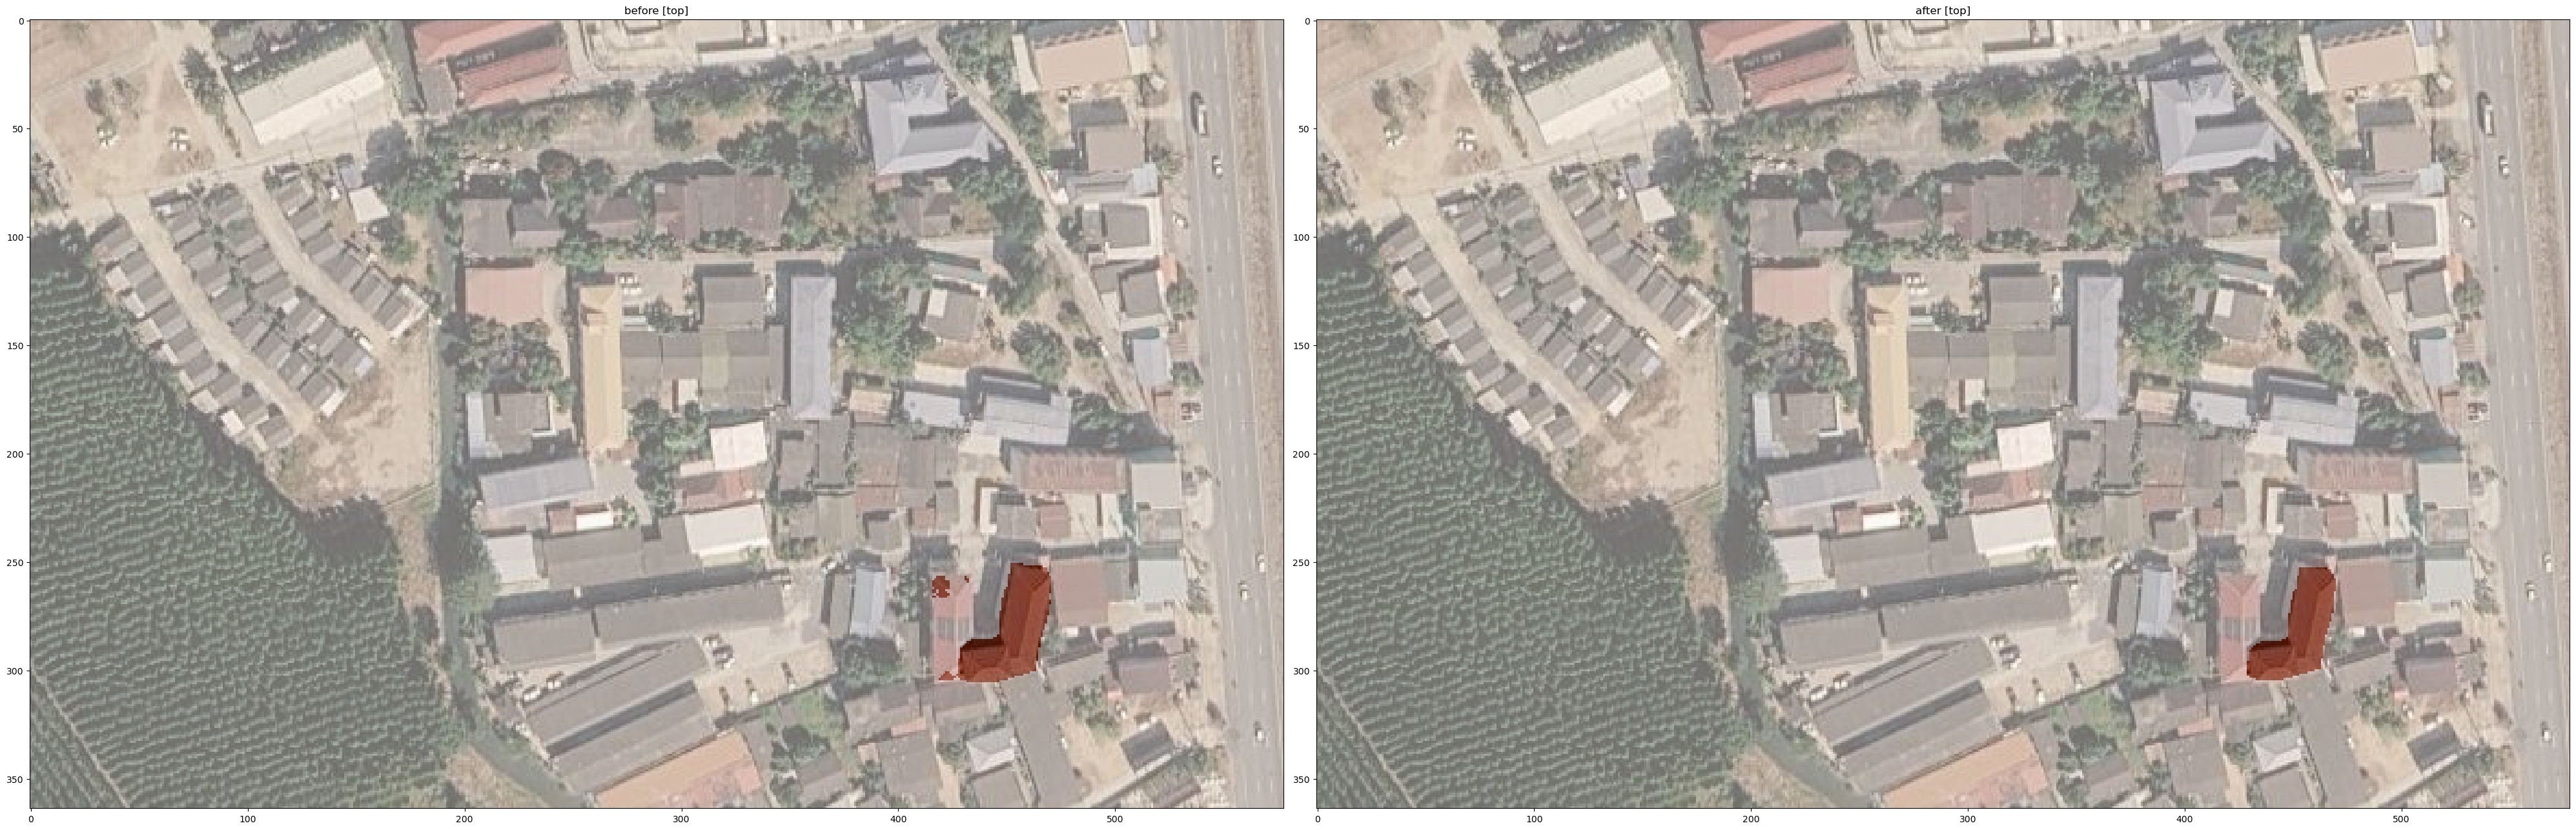

In [17]:
gray_bf = 1*(mask[0,:,:] == mask_id) 

gray_af = filling_holes(1*gray_bf)
gray_af = erosion(gray_af.astype(np.uint8), kernel_size=7)
gray_af = dilation(gray_af.astype(np.uint8), kernel_size=5)


fig, axs = plt.subplots(1, 2, figsize=(40, 30))

axs[0].imshow(image)
axs[0].imshow(gray_bf, cmap='Oranges', alpha=0.45)
axs[0].set_title("before [top]")
 

axs[1].imshow(image)
axs[1].imshow(gray_af, cmap='Oranges', alpha=0.45)
axs[1].set_title("after [top]")
 

plt.tight_layout()

#### Update the result

In [18]:
mask_2D = mask[0, :, :].copy()

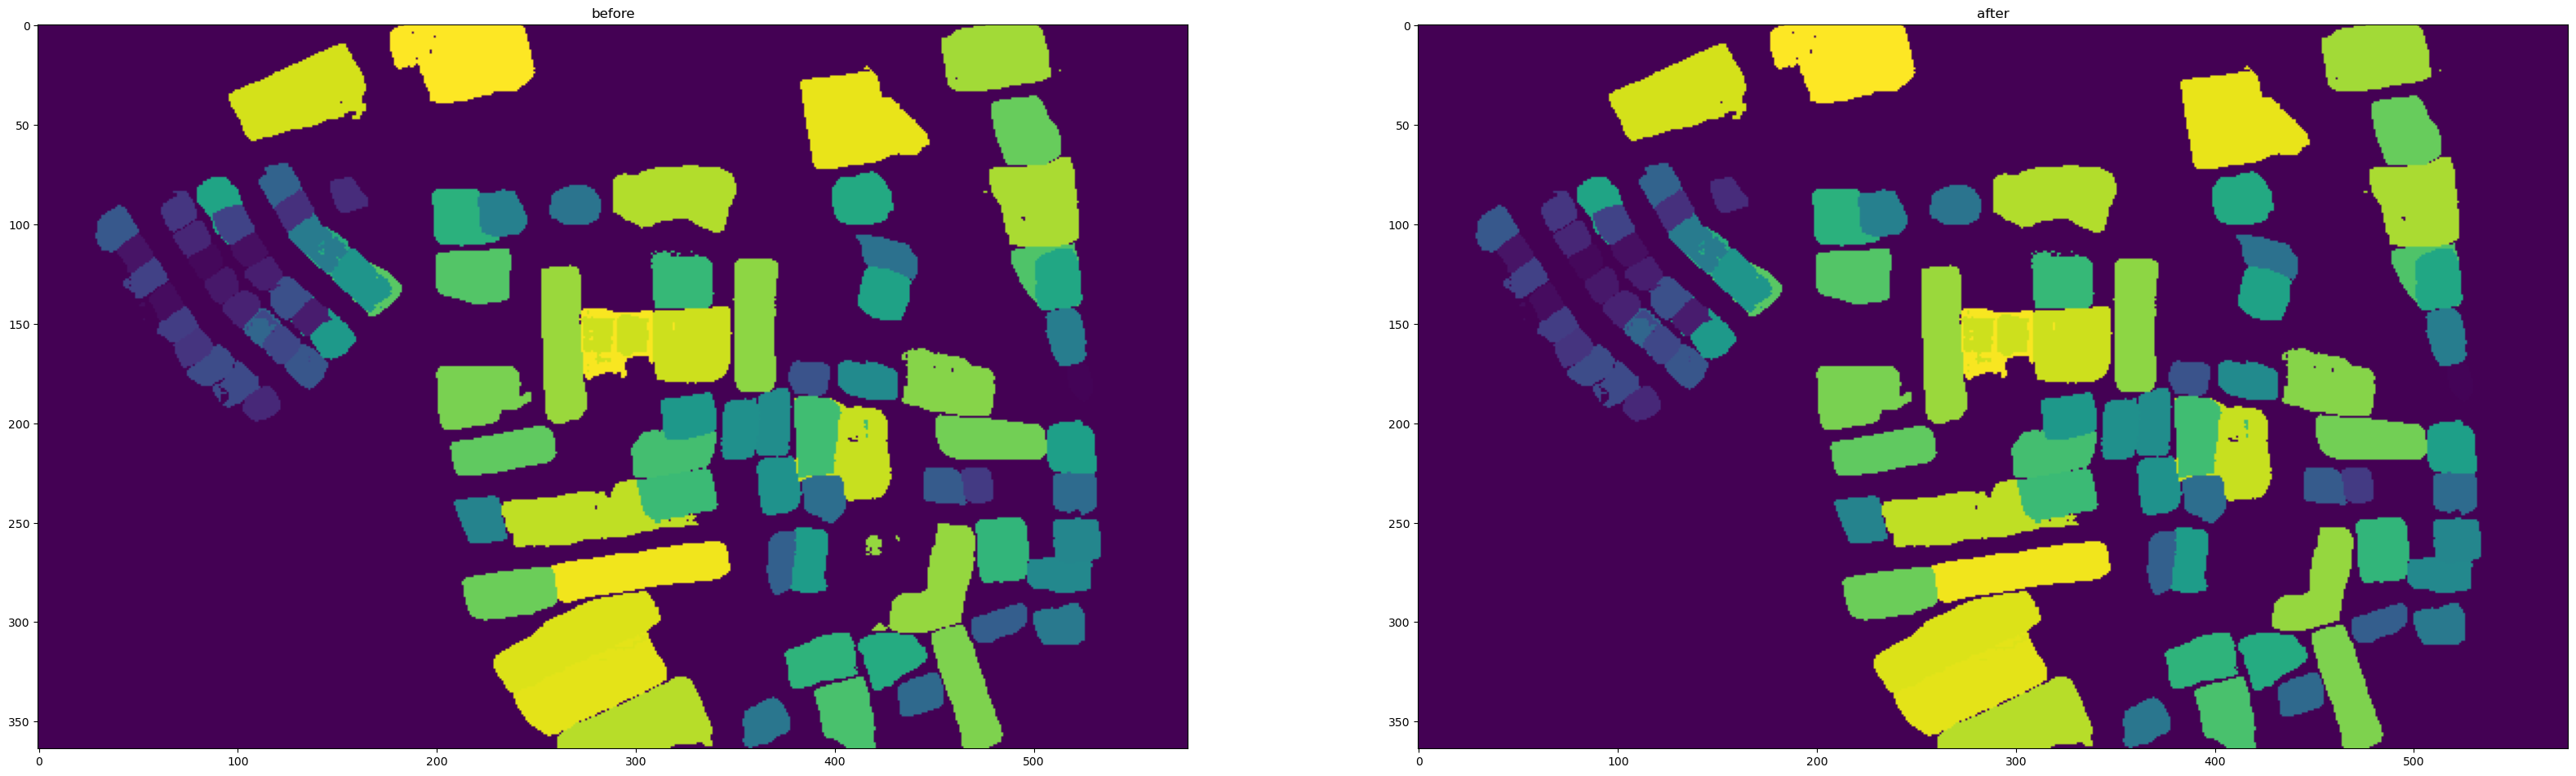

In [19]:
mask_2D[mask_2D == mask_id]  = mask_id*gray_af[mask_2D == mask_id]  

fig, axs = plt.subplots(1, 2, figsize=(40, 15))

axs[0].imshow(image)
axs[0].imshow(mask[0, :, :])
axs[0].set_title("before")

axs[1].imshow(image)
axs[1].imshow(mask_2D)
axs[1].set_title("after")

mask_2D_after = mask_2D.reshape(1, mask_2D.shape[0], mask_2D.shape[1])

In [20]:
mask_2D_after.shape

(1, 364, 578)

In [21]:
destination_tif = "sam_output/masks_new_edited.tif"
meta_source_tif = "sam_output/masks_new.tif"
save_raster_and_write_meta(mask_2D_after, destination_tif, meta_source_tif)

Modified image saved to sam_output/masks_new_edited.tif


In [22]:
mask_2D.reshape(1, mask_2D.shape[0], mask_2D.shape[1]) 


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 364, 578), dtype=int32)

Text(0.5, 1.0, 'after')

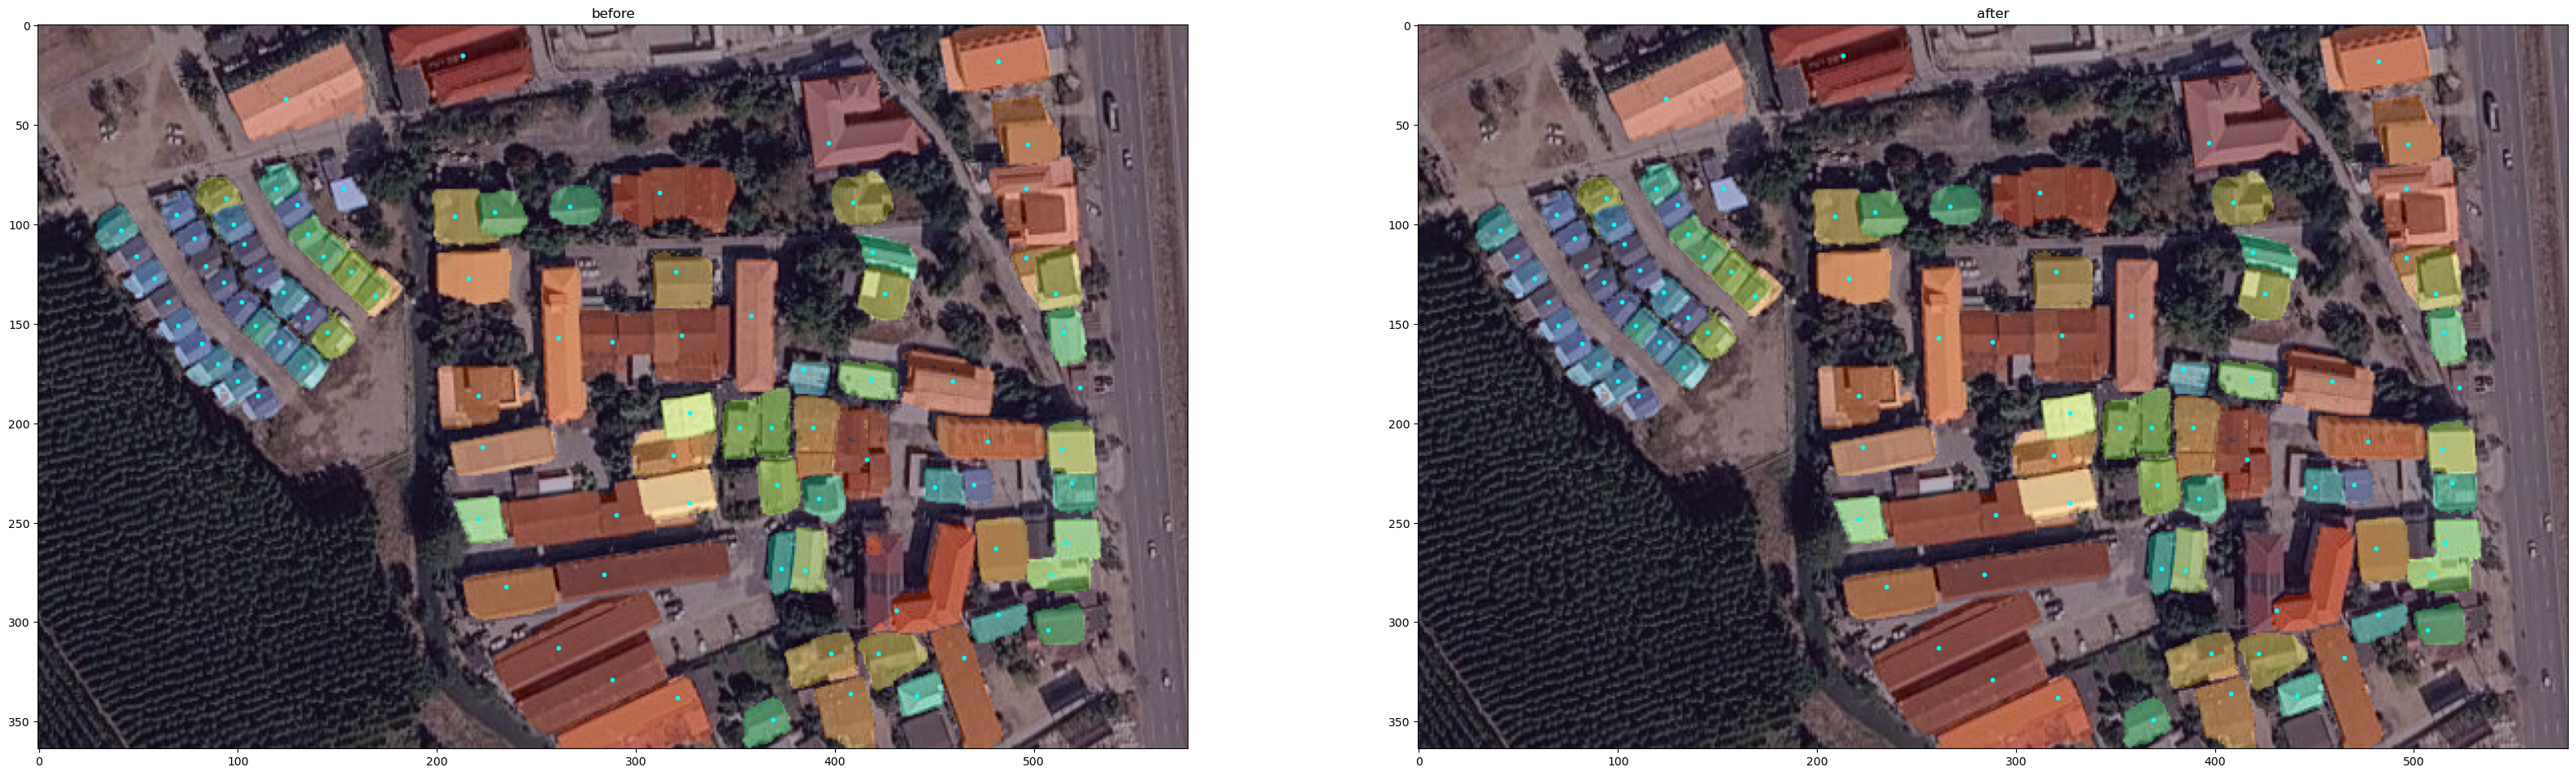

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(40, 30))
 
axs[0].imshow(image)
axs[0].imshow(mask_uint8[0,:,:], cmap='turbo', alpha=0.35)
axs[0].scatter(pixel_x, pixel_y, c='cyan', s=10)
axs[0].set_title("before")

axs[1].imshow(image)
axs[1].imshow(mask_2D, cmap='turbo', alpha=0.35)
axs[1].scatter(pixel_x, pixel_y, c='cyan', s=10)
axs[1].set_title("after")

#### Check if it can be used as a map

In [25]:
m = leafmap.Map()
m.add_raster(clipped_satellite_file, layer_name="Image") 
m.add_circle_markers_from_xy(center_geojson, radius=3, color="red", fill_color="yellow", fill_opacity=0.8
) 
m.add_raster(extracted_masks, cmap="jet", layer_name="Building masks (before)") 
m.add_raster(destination_tif, cmap="jet", layer_name="Building masks (after)") 
m

Map(center=[13.053346999999999, 100.924553], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Warping mask